<a href="https://colab.research.google.com/github/davidsonsantana89/dass--CESAR_SCHOOL-Topicos_Contemporaneos/blob/main/exercicios/dass_09_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DAVIDSON ALVES SANTOS DE SANTANA

dass@cesar.school

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights, VGG16_Weights, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!mkdir data

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [5]:
# Baixa e extrai o dataset
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  2160k      0  0:00:05  0:00:05 --:--:-- 2957k
Archive:  data/animais.zip
   creating: data/animais/
   creating: data/animais/val/
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  

In [45]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [46]:
model = models.resnet18(weights="IMAGENET1K_V1")

In [8]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
# Congelar todas as camadas
for param in model.parameters():
    print(param.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

In [35]:
model.layer4[1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [39]:
# # DESCONGELAR A CAMADA model.layer4[1]
# for param in model.layer4[1].parameters():
#     param.requires_grad = True

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [48]:
model.fc.weight.shape

torch.Size([1000, 512])

In [49]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [50]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False #está no segundo notebook da aula sobre PyTorch

In [51]:
model.fc.in_features

512

In [52]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [54]:
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Epoch 1, Train Loss: 0.688, Train Accuracy: 57.50%
Epoch 1, Val Loss: 0.464, Val Accuracy: 82.79%


100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


Epoch 2, Train Loss: 0.465, Train Accuracy: 79.75%
Epoch 2, Val Loss: 0.275, Val Accuracy: 90.98%


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Epoch 3, Train Loss: 0.349, Train Accuracy: 85.75%
Epoch 3, Val Loss: 0.194, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:01<00:00,  8.95it/s]


Epoch 4, Train Loss: 0.286, Train Accuracy: 91.00%
Epoch 4, Val Loss: 0.164, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Epoch 5, Train Loss: 0.262, Train Accuracy: 87.75%
Epoch 5, Val Loss: 0.160, Val Accuracy: 95.90%
Treinamento concluído


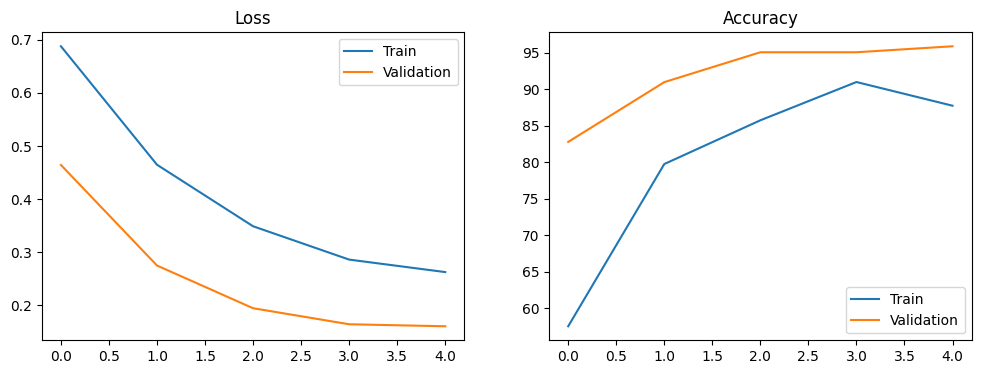

In [55]:
# com augmentation
plot_history(history)

In [57]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 95.90%


In [58]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

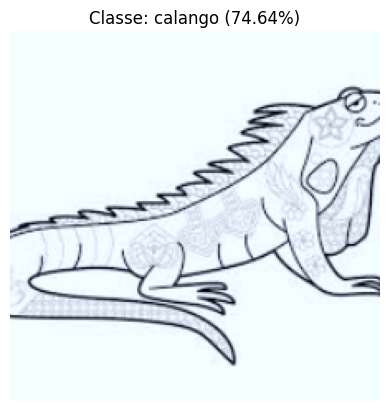

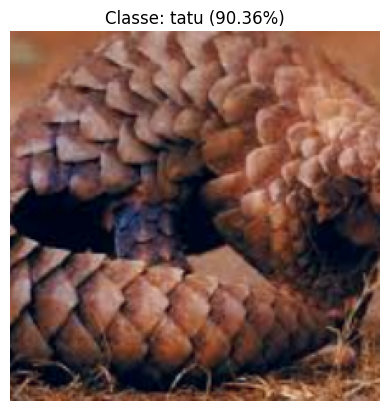

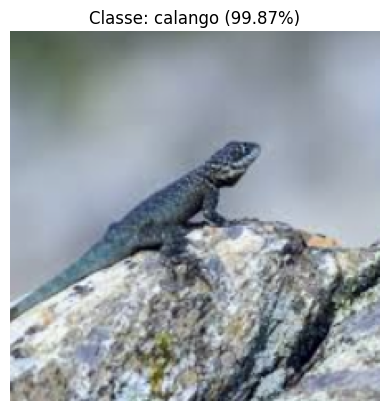

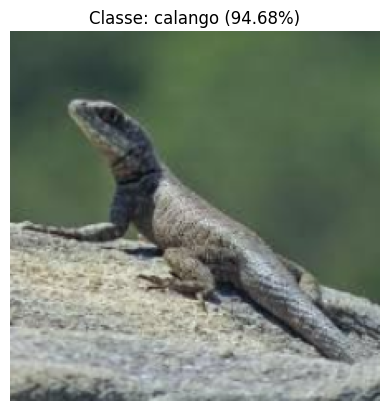

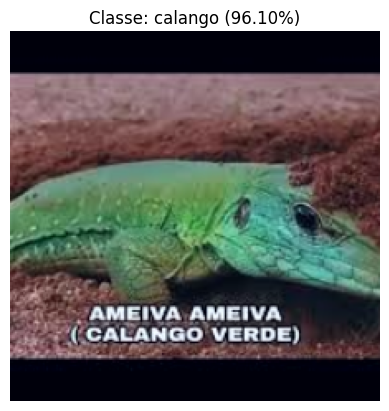

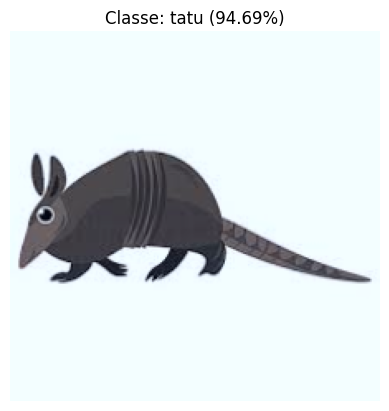

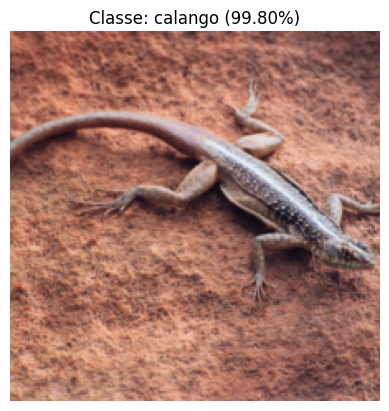

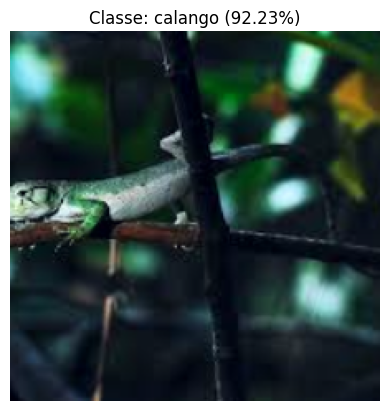

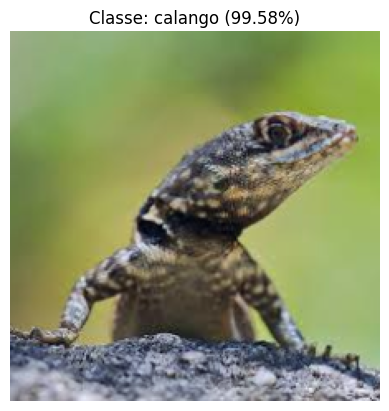

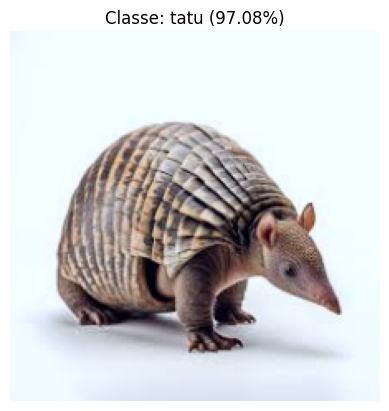

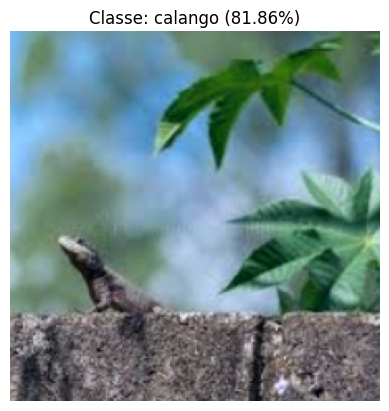

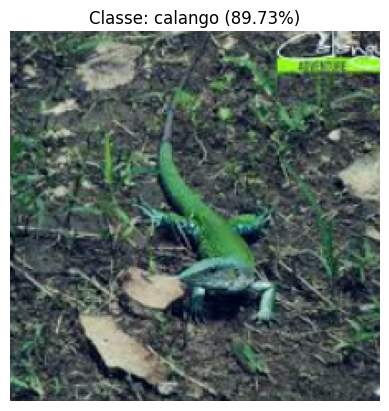

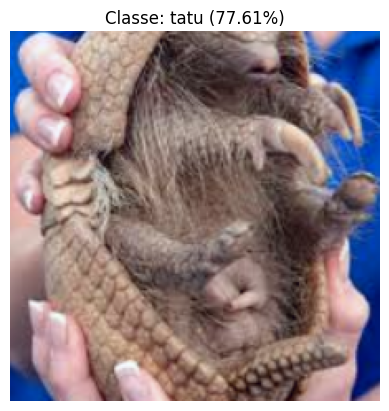

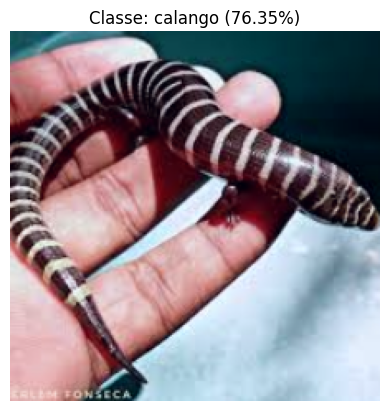

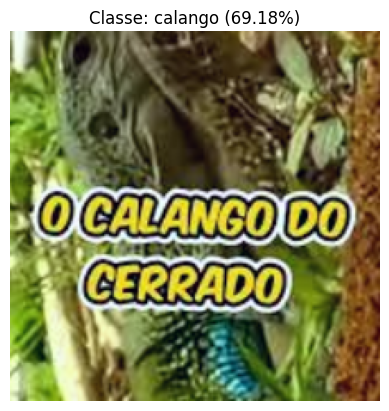

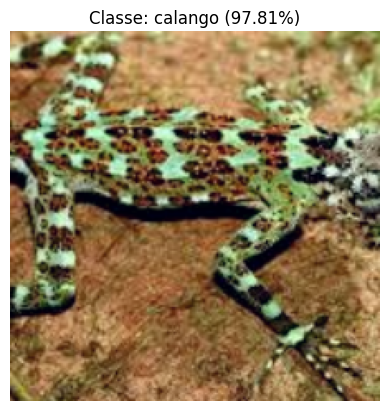

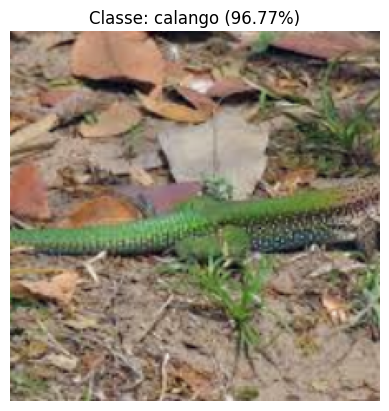

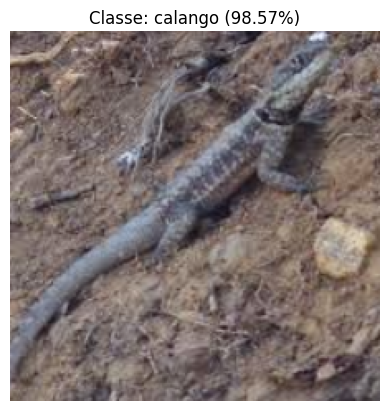

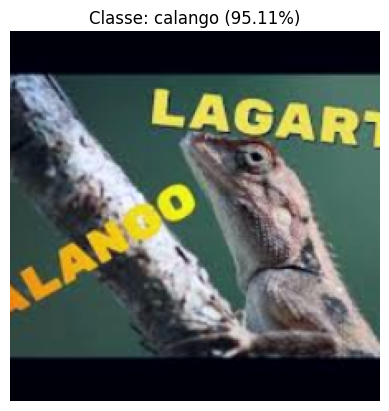

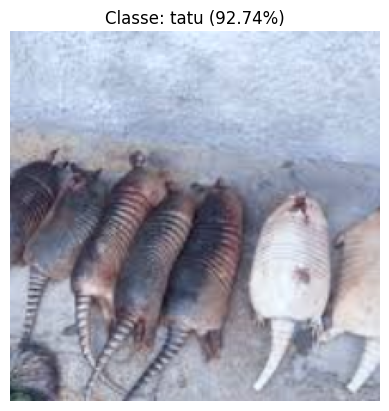

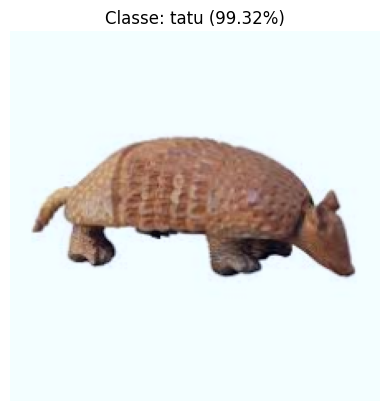

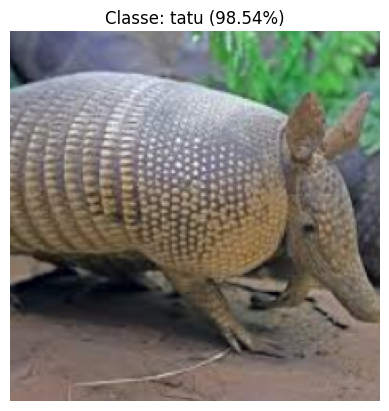

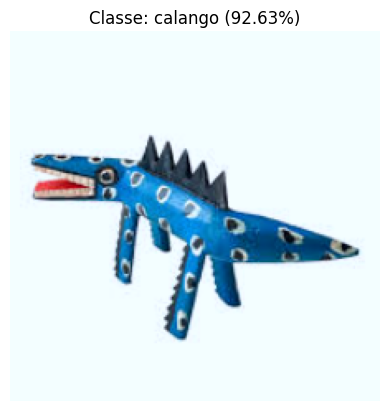

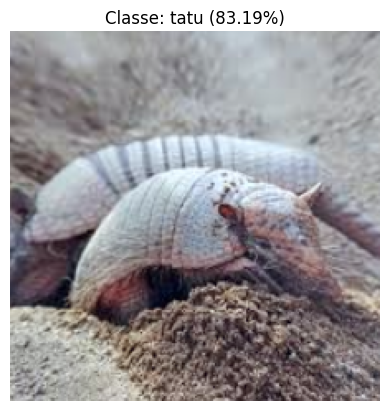

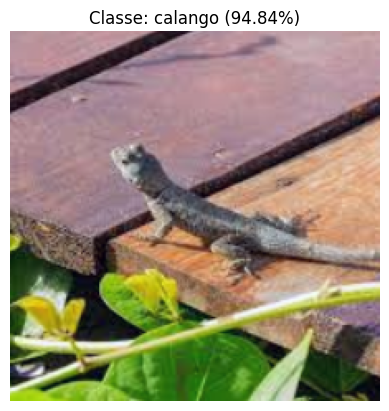

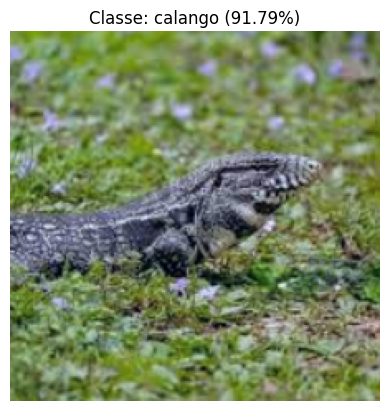

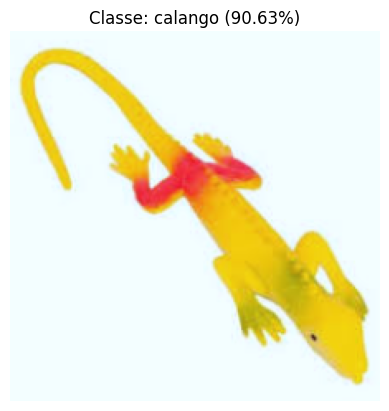

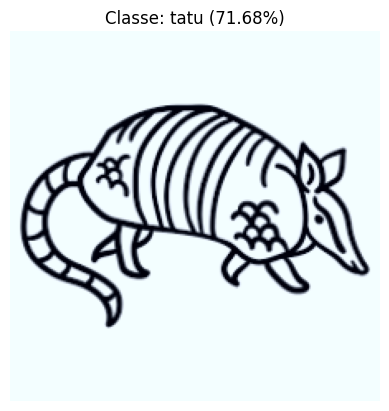

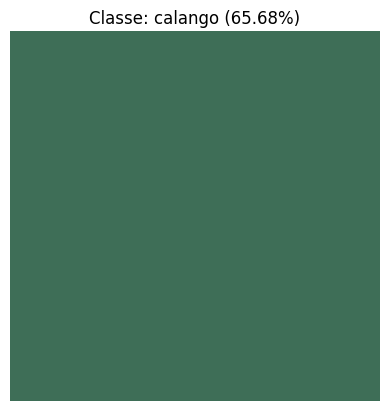

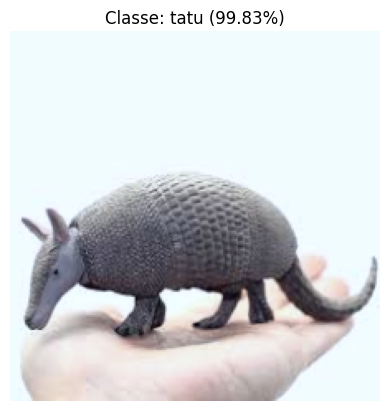

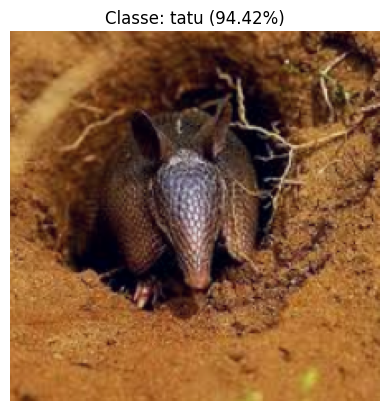

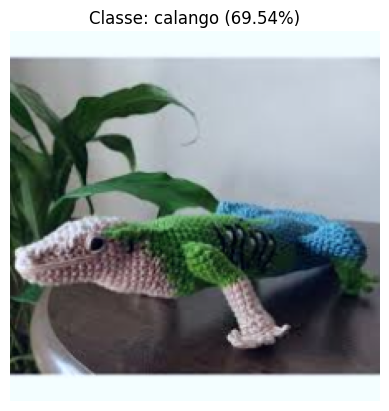

In [59]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

In [60]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)


model = models.resnet18(weights="IMAGENET1K_V1")


# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False


# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)
print()

test_model(model, val_loader)

100%|██████████| 13/13 [00:01<00:00,  8.46it/s]


Epoch 1, Train Loss: 0.710, Train Accuracy: 58.00%
Epoch 1, Val Loss: 0.419, Val Accuracy: 86.89%


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


Epoch 2, Train Loss: 0.366, Train Accuracy: 86.75%
Epoch 2, Val Loss: 0.239, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


Epoch 3, Train Loss: 0.246, Train Accuracy: 91.25%
Epoch 3, Val Loss: 0.255, Val Accuracy: 87.70%


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Epoch 4, Train Loss: 0.204, Train Accuracy: 93.75%
Epoch 4, Val Loss: 0.163, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:01<00:00,  7.49it/s]


Epoch 5, Train Loss: 0.175, Train Accuracy: 94.00%
Epoch 5, Val Loss: 0.201, Val Accuracy: 94.26%
Treinamento concluído

Acurácia da rede na base de teste: 94.26%


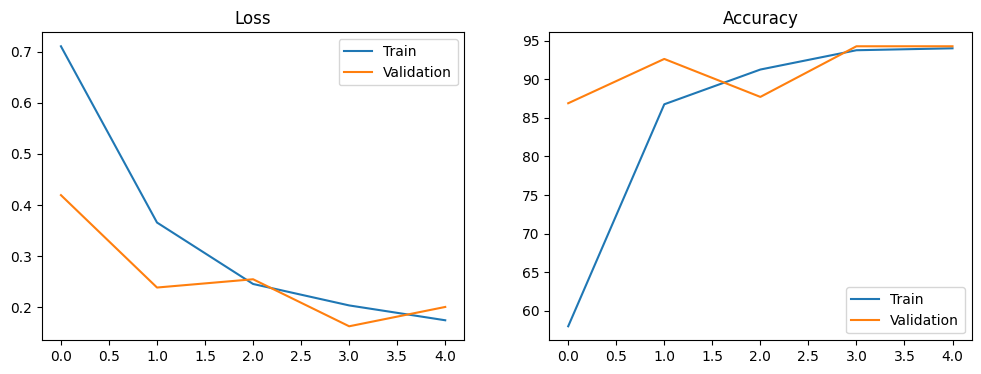

In [61]:
# sem augmentation
plot_history(history)

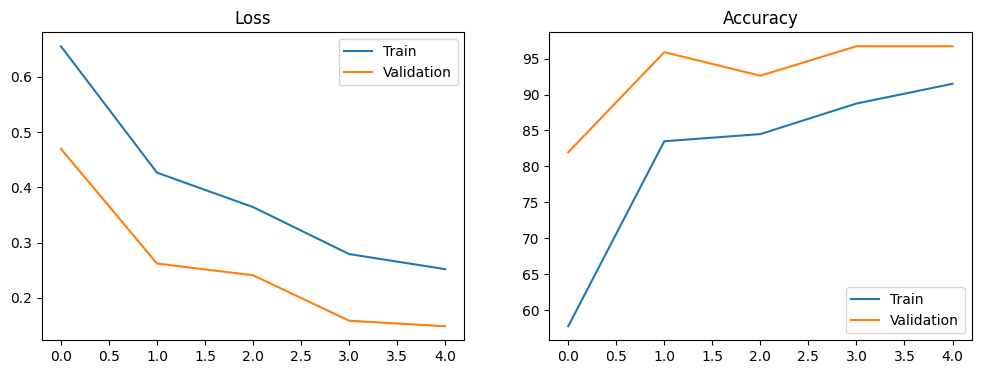

In [ ]:
# com augmentation
plot_history(history)

Além da redução na acurácia, quando comparada com a do treinamento com data augmentation, o modelo sem data augmentation, em determinada época, apresentou over fitting.

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [63]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)


model = models.resnet18(weights="IMAGENET1K_V1")


# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False


# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)


# # DESCONGELAR A CAMADA model.layer4[1]
for param in model.layer2[1].parameters():
    param.requires_grad = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)
print()

test_model(model, val_loader)

100%|██████████| 13/13 [00:01<00:00,  7.96it/s]


Epoch 1, Train Loss: 0.646, Train Accuracy: 62.75%
Epoch 1, Val Loss: 0.432, Val Accuracy: 81.97%


100%|██████████| 13/13 [00:01<00:00,  7.10it/s]


Epoch 2, Train Loss: 0.414, Train Accuracy: 85.25%
Epoch 2, Val Loss: 0.260, Val Accuracy: 90.16%


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


Epoch 3, Train Loss: 0.333, Train Accuracy: 87.00%
Epoch 3, Val Loss: 0.176, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Epoch 4, Train Loss: 0.271, Train Accuracy: 90.50%
Epoch 4, Val Loss: 0.162, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Epoch 5, Train Loss: 0.249, Train Accuracy: 91.75%
Epoch 5, Val Loss: 0.151, Val Accuracy: 95.08%
Treinamento concluído

Acurácia da rede na base de teste: 95.08%


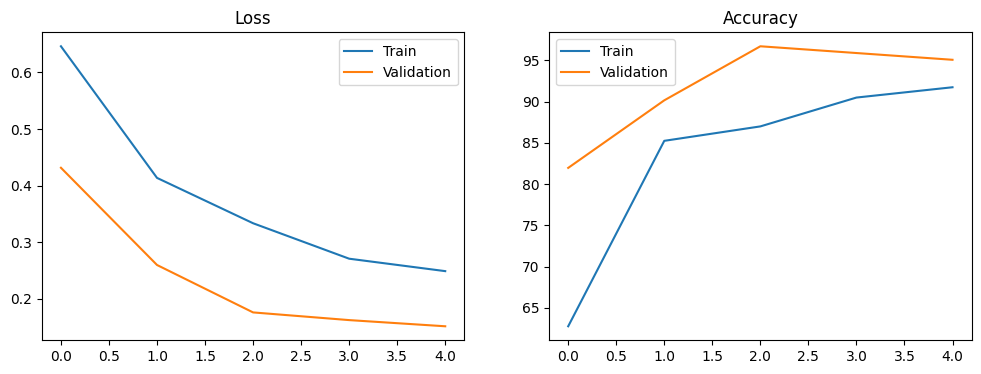

In [64]:
plot_history(history)

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

GoogleNet

In [65]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)


model = models.googlenet(weights="IMAGENET1K_V1")


# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False


# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)
print()

test_model(model, val_loader)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 216MB/s]
100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Epoch 1, Train Loss: 0.703, Train Accuracy: 50.75%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.604, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


Epoch 2, Train Loss: 0.581, Train Accuracy: 75.50%
Epoch 2, Val Loss: 0.459, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Epoch 3, Train Loss: 0.492, Train Accuracy: 83.50%
Epoch 3, Val Loss: 0.381, Val Accuracy: 90.16%


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


Epoch 4, Train Loss: 0.409, Train Accuracy: 88.50%
Epoch 4, Val Loss: 0.311, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


Epoch 5, Train Loss: 0.375, Train Accuracy: 87.25%
Epoch 5, Val Loss: 0.290, Val Accuracy: 93.44%
Treinamento concluído

Acurácia da rede na base de teste: 93.44%


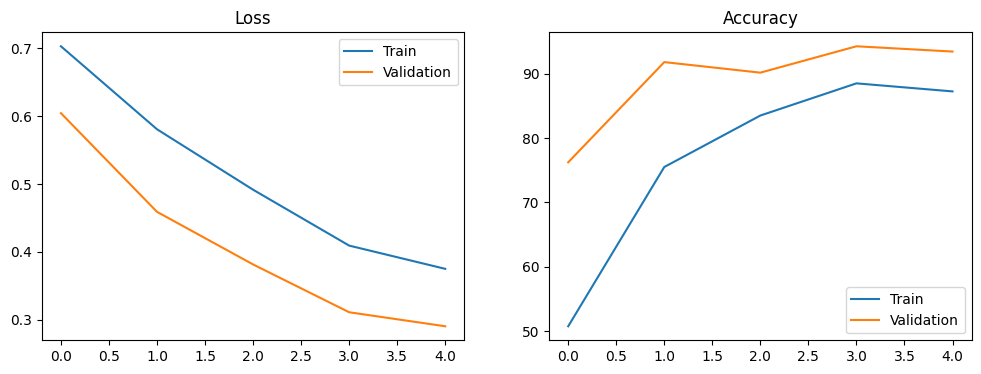

In [66]:
plot_history(history)

VGG19

In [73]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)


model = models.vgg19(weights="IMAGENET1K_V1")


# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False


# Substituir a última camada
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)
print()

test_model(model, val_loader)

100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


Epoch 1, Train Loss: 0.497, Train Accuracy: 71.00%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.156, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 2, Train Loss: 0.236, Train Accuracy: 91.00%
Epoch 2, Val Loss: 0.113, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:03<00:00,  4.09it/s]


Epoch 3, Train Loss: 0.225, Train Accuracy: 90.75%
Epoch 3, Val Loss: 0.101, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


Epoch 4, Train Loss: 0.175, Train Accuracy: 91.75%
Epoch 4, Val Loss: 0.100, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 5, Train Loss: 0.226, Train Accuracy: 90.75%
Epoch 5, Val Loss: 0.104, Val Accuracy: 95.90%
Treinamento concluído

Acurácia da rede na base de teste: 95.90%


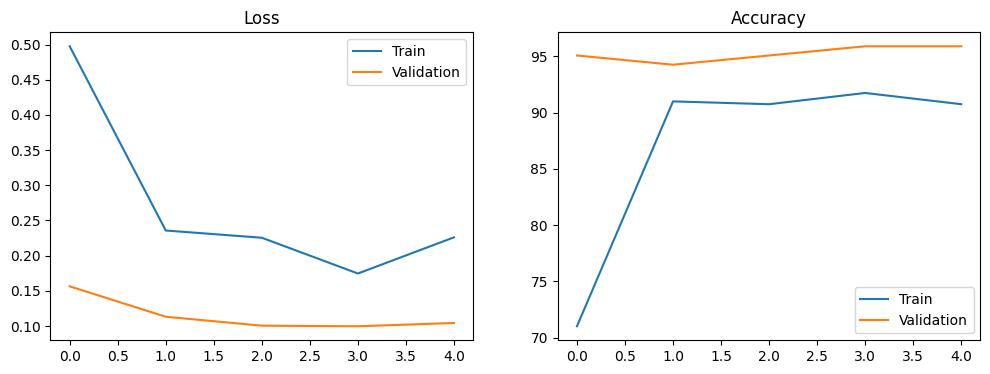

In [74]:
plot_history(history)